<a href="https://colab.research.google.com/github/Juliarty/kdd-project/blob/main/Kdd_eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Подготовка данных и модели.

В качестве данных взят датасет https://www.kaggle.com/pavelbiz/eyes-rtte, который представляет собой набор изображений мужских и женских глаз. Также в данном ноутбуке используется модель, обученная с использованием кода из https://www.kaggle.com/davidbroberts/male-or-female-eyes-simple-cnn.

In [34]:
!gdown --id 1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF 

Downloading...
From: https://drive.google.com/uc?id=1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF
To: /content/eyes-rtte-train-test-split.zip
100% 43.1M/43.1M [00:00<00:00, 60.2MB/s]


In [36]:
!unzip -q -n eyes-rtte-train-test-split.zip

In [7]:
# Do imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



In [38]:
# Setup some config variables
batch_size = 50
image_size = (256,256)
base_path = './data'
test_path = base_path + '/test'
train_path = base_path + '/train'

seed = 42

In [39]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = image_size,
    batch_size = batch_size,
)

Found 1154 files belonging to 2 classes.


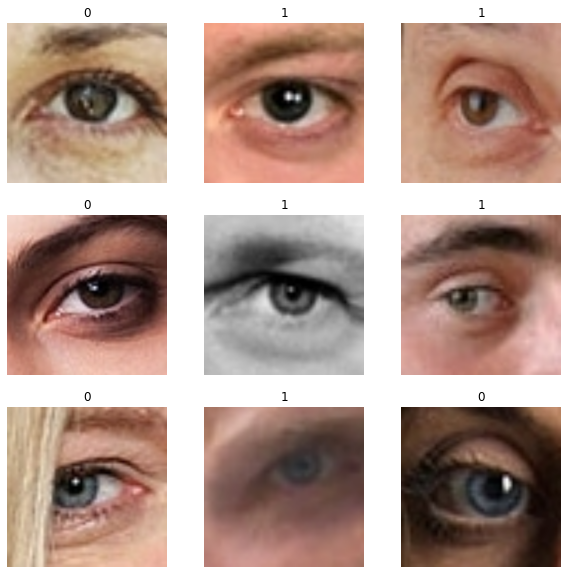

In [40]:
# Display a few images, label 0 is female, label 1 is male
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [41]:
# Setup the model. This is a stock model definition from the keras website. keras.io
#
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    x = inputs
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [42]:
# download the trained model
!mkdir model
!cd model
!gdown --id 19ZoXl-McdOlTlEbtsl65Ip8zpUo0PpC_ -O model/model_parameters.h5

mkdir: cannot create directory ‘model’: File exists
Downloading...
From: https://drive.google.com/uc?id=19ZoXl-McdOlTlEbtsl65Ip8zpUo0PpC_
To: /content/model/model_parameters.h5
100% 33.6M/33.6M [00:00<00:00, 65.3MB/s]


In [43]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights('./model/model_parameters.h5')
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


24/24 - 119s - loss: 0.1395 - accuracy: 0.9497 - 119s/epoch - 5s/step
Restored model, accuracy: 94.97%
